# Covid Sales Forecasting

### 목차

#### 1. 모듈 및 데이터 임포트
#####  <GPU 확인>
#####  <데이터 임포트>
<br/>

#### 2. 데이터 전처리
#####  2.1. MinMaxScaling
#####  2.2. 데이터 연관성 분석
#####  2.3. 이상치 처리
#####  2.4. 데이터셋 분할
#####  <결과기록용 데이터셋 저장>
#####  <테스트셋 csv 저장>
<br/>

#### 3. 딥러닝
#####  3.1. 네트워크 모델
#####  <Plot model 저장>
#####  3.2. 학습
<br/>

#### 4. 결과 표시
#####  4.1. 손실 함수 그래프
#####  <채점용 csv 저장>
#####  4.2. 측정 성능 출력
#####  4.3. 예측 그래프

##### <화면 가로 확장>

In [1]:
# 화면 가로 확장 코드 (기본 width 50%)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### 1. 모듈 임포트

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import tensorflow as tf
import csv
import os
import datetime
import h5py

##### <GPU 확인>

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

#### 최종 데이터 Import

In [4]:
Data_Combined=pd.read_csv('./Data/2021_Data_Combined.csv', encoding='cp949')
Data_Combined

,Unnamed: 0,날짜,확진자수(양성),검사수,확진자 증가량,검사수 증가량,18시 전 규제 인원수,18시 후 규제 인원수,영업 제한 시각,평균기온(°C),강수여부,일강수량(mm),평균 풍속(m/s),Won
0,0,20210101,61753,4269308,1027,55436,5,5,21,-4.2,0.0,0.0,2.0,0
1,1,20210102,62573,4302790,820,33482,5,5,21,-5.0,0.0,0.0,2.6,0
2,2,20210103,63230,4340830,657,38040,5,5,21,-5.6,0.0,0.0,2.0,0
3,3,20210104,64250,4376600,1020,35770,5,5,21,-3.5,0.0,0.0,1.7,249789
4,4,20210105,64964,4439352,714,62752,5,5,21,-5.5,0.0,0.0,2.9,211252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,321,20211118,406065,15845430,3290,3290,10,10,27,11.9,0.0,0.0,2.4,322402
322,322,20211119,409099,15848464,3034,3034,10,10,27,12.9,0.0,0.0,1.9,55371
323,323,20211120,412305,15851670,3206,3206,10,10,27,10.4,0.0,0.0,1.6,0
324,324,20211121,415425,15854790,3120,3120,10,10,27,10.4,1.0,5.9,1.9,0


In [5]:
Data_Combined['Won'].max()

1310714

### 2. 데이터 전처리

#### 2.1. Min-Max Scaling

In [6]:
from sklearn.preprocessing import MinMaxScaler
# 정규화 과정을 거쳐 데이터 범위를 원하는 범위로 제한. 그래프는 동일하나 손실 정도를 확인하기에 더 좋음.
# 배치 정규화는 기울기 소멸 문제를 해결하기는 좋으나, RNN의 경우 계층별로 미니 정규화 적용이 필요해 모델이 복잡해지고 효율이 저하됨.
Data_Combined.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['확진자수(양성)', '검사수', '확진자 증가량', '검사수 증가량', '18시 전 규제 인원수', '18시 후 규제 인원수', '영업 제한 시각', '평균기온(°C)', '강수여부', '일강수량(mm)', '평균 풍속(m/s)', 'Won']
Data_scaled = scaler.fit_transform(Data_Combined[scale_cols])
Data_scaled = pd.DataFrame(Data_scaled)
Data_scaled.columns = scale_cols

Data_scaled.insert(0, '날짜', Data_Combined['날짜'])
Data_scaled

,날짜,확진자수(양성),검사수,확진자 증가량,검사수 증가량,18시 전 규제 인원수,18시 후 규제 인원수,영업 제한 시각,평균기온(°C),강수여부,일강수량(mm),평균 풍속(m/s),Won
0,20210101,0.000000,0.000000,0.246169,0.771646,0.0,0.285714,0.0,0.229614,0.0,0.000000,0.189189,0.000000
1,20210102,0.002300,0.002889,0.177215,0.457038,0.0,0.285714,0.0,0.212446,0.0,0.000000,0.351351,0.000000
2,20210103,0.004143,0.006172,0.122918,0.522355,0.0,0.285714,0.0,0.199571,0.0,0.000000,0.189189,0.000000
3,20210104,0.007004,0.009259,0.243837,0.489825,0.0,0.285714,0.0,0.244635,0.0,0.000000,0.108108,0.190575
4,20210105,0.009007,0.014674,0.141905,0.876487,0.0,0.285714,0.0,0.201717,0.0,0.000000,0.432432,0.161173
...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,20211118,0.965815,0.998948,1.000000,0.024376,1.0,1.000000,1.0,0.575107,0.0,0.000000,0.297297,0.245974
322,20211119,0.974325,0.999210,0.914724,0.020707,1.0,1.000000,1.0,0.596567,0.0,0.000000,0.162162,0.042245
323,20211120,0.983318,0.999487,0.972019,0.023172,1.0,1.000000,1.0,0.542918,0.0,0.000000,0.081081,0.000000
324,20211121,0.992070,0.999756,0.943371,0.021940,1.0,1.000000,1.0,0.542918,1.0,0.076227,0.162162,0.000000


#### 2.2.. 데이터 연관성 분석

In [7]:
Data_scaled.columns

Index(['날짜', '확진자수(양성)', '검사수', '확진자 증가량', '검사수 증가량', '18시 전 규제 인원수',
       '18시 후 규제 인원수', '영업 제한 시각', '평균기온(°C)', '강수여부', '일강수량(mm)',
       '평균 풍속(m/s)', 'Won'],
      dtype='object')

In [8]:
import scipy.stats as stats

# 피어슨 stat을 이용하면 피어슨 상관계수와 p-value값이 출력되는데 상관계수는 양 or 음의 비례관계 정도를, p-value는 상관 정도를 보여준다. (0에 가까울수록 영향이 크다.)
def P_value(dataset, c1, c2):
    Correlation=stats.pearsonr(dataset[c1], dataset[c2])
    print('< '+c1+'-'+c2+' >')
    print('P-value ==>> %.3f\n' %Correlation[1])

for p in range(1, len(Data_scaled.columns)-1):
    P_value(Data_scaled, Data_scaled.columns[p], 'Won')

< 확진자수(양성)-Won >
P-value ==>> 0.093

< 검사수-Won >
P-value ==>> 0.029

< 확진자 증가량-Won >
P-value ==>> 0.537

< 검사수 증가량-Won >
P-value ==>> 0.000

< 18시 전 규제 인원수-Won >
P-value ==>> 0.263

< 18시 후 규제 인원수-Won >
P-value ==>> 0.660

< 영업 제한 시각-Won >
P-value ==>> 0.079

< 평균기온(°C)-Won >
P-value ==>> 0.006

< 강수여부-Won >
P-value ==>> 0.061

< 일강수량(mm)-Won >
P-value ==>> 0.027

< 평균 풍속(m/s)-Won >
P-value ==>> 0.783



In [9]:
#Data_P = Data_scaled.drop([Data_scaled.columns[1], Data_scaled.columns[3], Data_scaled.columns[4], Data_scaled.columns[5], Data_scaled.columns[7], Data_scaled.columns[9]], axis=1)
Data_P = Data_scaled.loc[:, ['날짜', '검사수', '검사수 증가량', '영업 제한 시각', '평균기온(°C)', '일강수량(mm)', 'Won']]

In [10]:
Data_P

,날짜,검사수,검사수 증가량,영업 제한 시각,평균기온(°C),일강수량(mm),Won
0,20210101,0.000000,0.771646,0.0,0.229614,0.000000,0.000000
1,20210102,0.002889,0.457038,0.0,0.212446,0.000000,0.000000
2,20210103,0.006172,0.522355,0.0,0.199571,0.000000,0.000000
3,20210104,0.009259,0.489825,0.0,0.244635,0.000000,0.190575
4,20210105,0.014674,0.876487,0.0,0.201717,0.000000,0.161173
...,...,...,...,...,...,...,...
321,20211118,0.998948,0.024376,1.0,0.575107,0.000000,0.245974
322,20211119,0.999210,0.020707,1.0,0.596567,0.000000,0.042245
323,20211120,0.999487,0.023172,1.0,0.542918,0.000000,0.000000
324,20211121,0.999756,0.021940,1.0,0.542918,0.076227,0.000000


#### 2.3. 이상치 처리

In [11]:
def get_outlier(df=None, column=None, weight=None):
    quantile_5 = np.percentile(df[column].values, 5)
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_50 = np.percentile(df[column].values, 50)
    quantile_75 = np.percentile(df[column].values, 75)
    quantile_95 = np.percentile(df[column].values, 95)
    
    IQR = quantile_75 - quantile_25
    IQR_weight = IQR * weight

    lowest_val = quantile_25-IQR_weight
    highest_val = quantile_75+IQR_weight
    
    outlier_index_lowest = df[column][df[column] < quantile_5].index
    outlier_index_low = df[column][df[column] < lowest_val].index
    outlier_index_high = df[column][df[column] > highest_val].index
    outlier_index_highest = df[column][df[column] > quantile_95].index
    
    return outlier_index_lowest, outlier_index_low, outlier_index_high, outlier_index_highest, quantile_5, quantile_25, quantile_50, quantile_75, quantile_95

In [12]:
WEIGHT=2.5
Lowest_list = get_outlier(df=Data_P, column='Won', weight=WEIGHT)[0]
Highest_list = get_outlier(df=Data_P, column='Won', weight=WEIGHT)[3]

print('Lowest Outlier ==>> {}\n'.format(Lowest_list))
print('Low Outlier ==>> {}\n'.format(get_outlier(df=Data_P, column='Won', weight=WEIGHT)[1]))
print('High Outlier ==>> {}\n'.format(get_outlier(df=Data_P, column='Won', weight=WEIGHT)[2]))
print('Highest Outlier ==>> {}\n'.format(Highest_list))

print('5% Value ==>> {}\n'.format(get_outlier(df=Data_P, column='Won', weight=WEIGHT)[4]))
print('25% Value ==>> {}\n'.format(get_outlier(df=Data_P, column='Won', weight=WEIGHT)[5]))
print('50% Value ==>> {}\n'.format(get_outlier(df=Data_P, column='Won', weight=WEIGHT)[6]))
print('75% Value ==>> {}\n'.format(get_outlier(df=Data_P, column='Won', weight=WEIGHT)[7]))
print('95% Value ==>> {}'.format(get_outlier(df=Data_P, column='Won', weight=WEIGHT)[8]))

Lowest Outlier ==>> Int64Index([], dtype='int64')

Low Outlier ==>> Int64Index([], dtype='int64')

High Outlier ==>> Int64Index([6, 13, 48, 63, 69, 90, 111, 140, 209, 258, 280, 293], dtype='int64')

Highest Outlier ==>> Int64Index([6, 13, 48, 63, 69, 76, 90, 111, 140, 209, 258, 269, 272, 280, 287,
            293, 307],
           dtype='int64')

5% Value ==>> 0.0

25% Value ==>> 0.0

50% Value ==>> 0.060951893395508105

75% Value ==>> 0.11486601958932308

95% Value ==>> 0.3809742247355259


In [13]:
WEIGHT_2R=np.sqrt(WEIGHT)

for i in range(len(Lowest_list)):
    Data_P['Won'][Lowest_list[i]] = Data_P['Won'][Lowest_list[i]]*WEIGHT_2R
    
for i in range(len(Highest_list)):
    Data_P['Won'][Highest_list[i]] = Data_P['Won'][Highest_list[i]]/WEIGHT_2R

C:\Users\82108\AppData\Local\Temp/ipykernel_13632/944755401.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_P['Won'][Highest_list[i]] = Data_P['Won'][Highest_list[i]]/WEIGHT_2R


In [14]:
high_val = get_outlier(df=Data_P, column='Won', weight=WEIGHT)[2].values.tolist()

for i in range(len(high_val)):
    Data_P['Won'][high_val[i]] = Data_P['Won'][high_val[i]]/WEIGHT_2R

C:\Users\82108\AppData\Local\Temp/ipykernel_13632/2415094863.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_P['Won'][high_val[i]] = Data_P['Won'][high_val[i]]/WEIGHT_2R


In [15]:
print('Quantity of Low Outlier ==>> {}\n'.format(len(get_outlier(df=Data_P, column='Won', weight=WEIGHT)[1])))
print('Quantity of High Outlier ==>> {}\n'.format(len(get_outlier(df=Data_P, column='Won', weight=WEIGHT)[2])))

Quantity of Low Outlier ==>> 0

Quantity of High Outlier ==>> 0



#### 2.4. 데이터셋 분할

In [16]:
TEST_SIZE = 14
WINDOW_SIZE = 7 # 얼마 동안의 과거 기반의 데이터에 기반하여 다음날의 값을 예측할 것인지 설정. 
BATCH_SIZE = 256

train = Data_P[:-TEST_SIZE]
test= Data_P[-TEST_SIZE:]
test = test.reset_index(drop=True) # 인덱스 초기화

In [17]:
from sklearn.model_selection import train_test_split

feature_cols = ['검사수', '검사수 증가량', '영업 제한 시각', '평균기온(°C)', '일강수량(mm)', 'Won']
label_cols = ['Won']

train_feature = train[feature_cols]
train_label = train[label_cols]

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.3, shuffle=False)

In [18]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [19]:
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, False) # 학습도 셔플 안해야 맞는게 아닌가??
valid_data = windowed_dataset(y_valid, WINDOW_SIZE, BATCH_SIZE, False)

In [20]:
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (211, 7, 1, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (211, 1, 1)


##### <결과기록용 데이터셋 저장>

In [21]:
train
train.to_csv('./Result/score/Learning_set.csv', index=False)

##### <평가용 csv 저장>

In [22]:
TESTSET = test['Won']
TESTSET.to_csv('./Result/score/Test_set.csv', index=False)

### 3. 딥러닝

#### 3.1. 네트워크 모델

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
import keras
LeakyReLU=tf.keras.layers.LeakyReLU(alpha=0.01)

#16-0.2-8-1
model = Sequential([
    Dense(16, activation='ELU', input_shape=[WINDOW_SIZE, 1]),
    Dense(8, activation='ELU'),
    Dense(4, activation='ELU'),
    Dense(1)
                    ])

model.summary()

model.compile(loss='mean_absolute_error', optimizer="Nadam", metrics=['mae'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7, 16)             32        
                                                                 
 dense_1 (Dense)             (None, 7, 8)              136       
                                                                 
 dense_2 (Dense)             (None, 7, 4)              36        
                                                                 
 dense_3 (Dense)             (None, 7, 1)              5         
                                                                 
Total params: 209
Trainable params: 209
Non-trainable params: 0
_________________________________________________________________


##### <Plot model 저장>

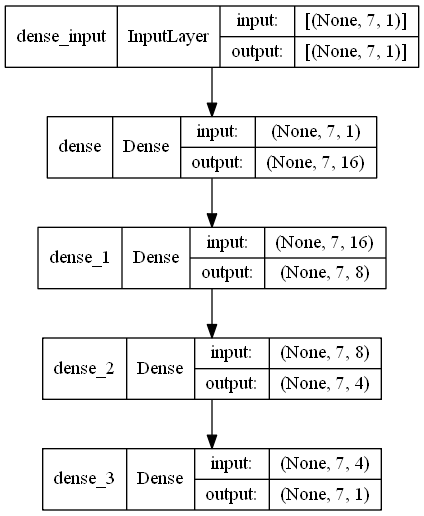

In [24]:

from keras.utils.vis_utils import plot_model
import pydot
import pydotplus
import graphviz

plot_model(model, to_file='./Result/model.png')
plot_model(model, to_file='./Result/model_shapes.png', show_shapes=True)


#### 3.2. 학습

In [25]:
#early_stop = EarlyStopping(monitor='val_loss', patience=20)

with tf.device('/GPU:0'):
    model_path = 'model'
    filename = os.path.join(model_path, 'tmp_checkpoint_Covid.h5')
    checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    history = model.fit(train_data, epochs=35, batch_size=BATCH_SIZE, validation_data=(valid_data), callbacks=[checkpoint])

Epoch 1/35
      1/Unknown - 1s 1s/step - loss: 0.0827 - mae: 0.0827
Epoch 00001: val_loss improved from inf to 0.07270, saving model to model\tmp_checkpoint_Covid.h5
1/1 [==============================] - 3s 3s/step - loss: 0.0827 - mae: 0.0827 - val_loss: 0.0727 - val_mae: 0.0727
Epoch 2/35
1/1 [==============================] - ETA: 0s - loss: 0.0811 - mae: 0.0811
Epoch 00002: val_loss improved from 0.07270 to 0.07219, saving model to model\tmp_checkpoint_Covid.h5
1/1 [==============================] - 0s 71ms/step - loss: 0.0811 - mae: 0.0811 - val_loss: 0.0722 - val_mae: 0.0722
Epoch 3/35
1/1 [==============================] - ETA: 0s - loss: 0.0804 - mae: 0.0804
Epoch 00003: val_loss improved from 0.07219 to 0.07174, saving model to model\tmp_checkpoint_Covid.h5
1/1 [==============================] - 0s 71ms/step - loss: 0.0804 - mae: 0.0804 - val_loss: 0.0717 - val_mae: 0.0717
Epoch 4/35
1/1 [==============================] - ETA: 0s - loss: 0.0796 - mae: 0.0796
Epoch 00004: val

1/1 [==============================] - ETA: 0s - loss: 0.0739 - mae: 0.0739
Epoch 00029: val_loss did not improve from 0.06981
1/1 [==============================] - 0s 51ms/step - loss: 0.0739 - mae: 0.0739 - val_loss: 0.0699 - val_mae: 0.0699
Epoch 30/35
1/1 [==============================] - ETA: 0s - loss: 0.0739 - mae: 0.0739
Epoch 00030: val_loss did not improve from 0.06981
1/1 [==============================] - 0s 51ms/step - loss: 0.0739 - mae: 0.0739 - val_loss: 0.0699 - val_mae: 0.0699
Epoch 31/35
1/1 [==============================] - ETA: 0s - loss: 0.0739 - mae: 0.0739
Epoch 00031: val_loss did not improve from 0.06981
1/1 [==============================] - 0s 55ms/step - loss: 0.0739 - mae: 0.0739 - val_loss: 0.0699 - val_mae: 0.0699
Epoch 32/35
1/1 [==============================] - ETA: 0s - loss: 0.0739 - mae: 0.0739
Epoch 00032: val_loss did not improve from 0.06981
1/1 [==============================] - 0s 52ms/step - loss: 0.0739 - mae: 0.0739 - val_loss: 0.0699 - 

In [26]:
model.load_weights(filename)
pred = model.predict(test['Won'])

### 4. 결과 표시

In [27]:
try:
    os.mkdir('./Result')
    print('폴더 생성 완료.')
    
except FileExistsError:
    print('해당 폴더가 이미 존재합니다.')

해당 폴더가 이미 존재합니다.


In [28]:
try:
    os.mkdir('./Result/Graph')
    os.mkdir('./Result/Data')
    print('폴더 생성 완료.')
    
except FileExistsError:
    print('해당 폴더가 이미 존재합니다.')

해당 폴더가 이미 존재합니다.


#### 4.1. 손실 함수 그래프

<function matplotlib.pyplot.show(close=None, block=None)>

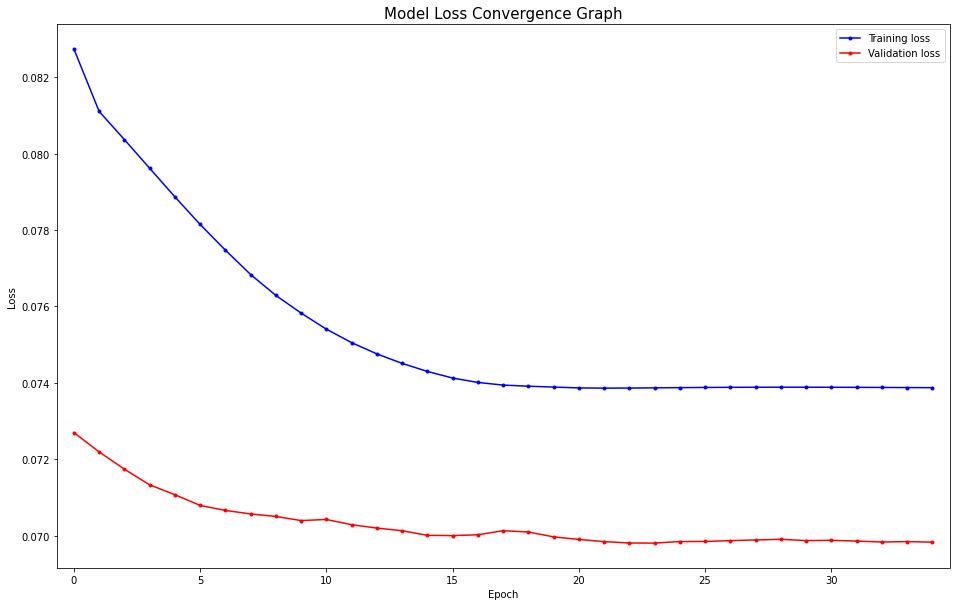

In [29]:
plt.figure(figsize=(16, 10))
plt.title('Model Loss Convergence Graph', size='15')
y_tloss = history.history['loss']
y_vloss = history.history['val_loss']
x_len = np.arange(len(y_tloss))
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.plot(x_len, y_tloss, "o-", c="blue", markersize=3)
plt.plot(x_len, y_vloss, "o-", c="red", markersize=3)
plt.margins(x=0.02)
plt.legend(['Training loss', 'Validation loss'])
plt.savefig('./Result/Graph/Model_Loss_Convergence_Graph.png')
plt.show

In [30]:
pred=pred.reshape(-1,1)

In [31]:
pred.shape

(14, 1)

##### <채점용 csv 저장>

In [32]:
PRED_df = pd.DataFrame(pred)
PRED_df.to_csv('./Result/score/Pred.csv', index=False)

#### 4.2. 측정 성능 출력

In [33]:
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_squared_log_error as MSLE

RMSE = np.sqrt(MSE(test['Won'], pred))
R2 = r2(test['Won'], pred)
print('r2 >> %.4f' %R2) # 1에 가까워야 좋음
print('MAE >> %.4f' %MAE(test['Won'], pred)) # 0에 가까워야 좋음
print('RMSE >> %.4f' %RMSE) # 0에 가까워야 좋음

r2 >> -0.0238
MAE >> 0.0588
RMSE >> 0.0817


In [34]:
RMSE_pct = round(1-RMSE, 5)*100
RMSE_Percentage='RMSE Accuracy = %.3f %%' %RMSE_pct
print(RMSE_Percentage)

RMSE Accuracy = 91.832 %


In [35]:
score = round(((1-RMSE)/2 + R2/2),4)
Final_score = 'Final Score = 0.5*r2 + 0.5*RMSE = %.4f' %score
print(Final_score)

Final Score = 0.5*r2 + 0.5*RMSE = 0.4472


#### 4.3. 예측 그래프

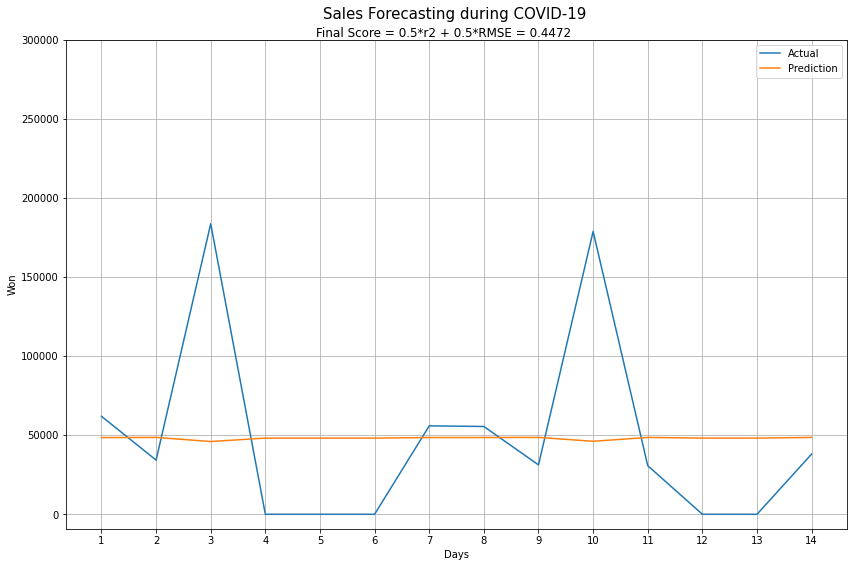

In [36]:
plt.figure(figsize=(14,9))
plt.title('Sales Forecasting during COVID-19 ', y=1.03, size='15')
plt.suptitle(Final_score, y=0.9, fontsize=12)
plt.plot(test['Won'], label='Actual')
plt.plot(pred, label='Prediction')
plt.xticks(range(0,14), labels=range(1,15))
plt.xlabel('Days')
plt.yticks([0, 0.0688, 0.1376, 0.2064, 0.2752, 0.344, 0.4128], 
           labels=[0, 50000, 100000, 150000, 200000, 250000, 300000])
plt.ylabel('Won')
plt.grid(True)
plt.legend()
plt.savefig('./Result/Graph/Result_Grpah.png')
plt.show()